# 오토인코더와 GAN을 사용한 표현 학습과 생성적 학습

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
import tensorflow as tf
from tensorflow import keras

if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')
# 공통 모듈 임포트
import numpy as np
import os
# 깔끔한 그래프 출력을 위해
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장 ' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

28x28 흑백 이미지를 그리기 위한 유틸리티 함수:

In [2]:
def plot_image(image):
    plt.imshow(image, 'binary')
    plt.axis('off')

## 과소완전 선형 오토인코더로 PCA 수행하기

3D 데이터셋을 만든다:

In [3]:
def generate_3d_data(m, w1=.1, w2=.3, noise=.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - .5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * .7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data


X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(0)

오토인코더를 만든다.

In [4]:
encoder = keras.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(keras.optimizers.experimental.SGD(1.5), 'mse')

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 3s 17ms/step - loss: 0.6168
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1642
Epoch 3/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0658
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0611
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0654
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0651
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0549
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0391
Epoch 9/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0286
Epoch 10/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 11/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0143
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0114
Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0

In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 3ms/step


그림 저장 linear_autoencoder_pca_plot


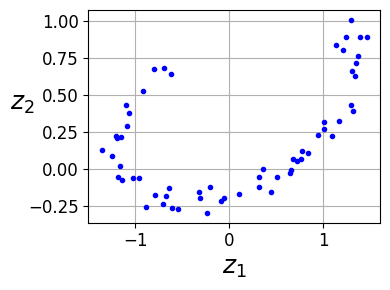

In [7]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)
save_fig('linear_autoencoder_pca_plot')
plt.show()

## 적층 오토인코더

### 케라스를 사용하여 적층 오토인코더 구현하기

MNIST 데이터셋을 사용한다:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [9]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((55000, 28, 28), (55000,), (5000, 28, 28), (5000,), (10000, 28, 28), (10000,))

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만든다.

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.math.round(y_true), tf.math.round(y_pred))

In [11]:
stacked_encoder = keras.Sequential(
    [keras.layers.Flatten(input_shape=[28, 28]), keras.layers.Dense(100, 'selu'), keras.layers.Dense(30, 'selu')]
)
stacked_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
stacked_ae = keras.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(keras.optimizers.experimental.SGD(1.5), 'binary_crossentropy', [rounded_accuracy])
# history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))
history = stacked_ae.fit(X_train, X_train, epochs=4, validation_data=(X_valid, X_valid))

Epoch 1/4
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3365 - rounded_accuracy: 0.8883 - val_loss: 0.3109 - val_rounded_accuracy: 0.9138
Epoch 2/4
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3043 - rounded_accuracy: 0.9163 - val_loss: 0.3008 - val_rounded_accuracy: 0.9204
Epoch 3/4
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2973 - rounded_accuracy: 0.9229 - val_loss: 0.2972 - val_rounded_accuracy: 0.9238
Epoch 4/4
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2932 - rounded_accuracy: 0.9265 - val_loss: 0.2933 - val_rounded_accuracy: 0.9263


### 재구성 시각화

이 함수는 오토인코더를 사용해 몇 개의 테스트 이미지를 처리한다. 그런 다음 원본 이미지와 재구성 이미지를 그린다:

In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 69ms/step
그림 저장 reconstruction_plot


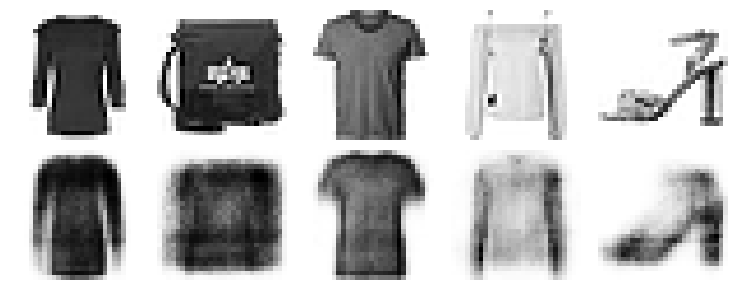

In [13]:
show_reconstructions(stacked_ae)
save_fig('reconstruction_plot')

### 패션 MNIST 데이터셋 시각화

In [14]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 930us/step


C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


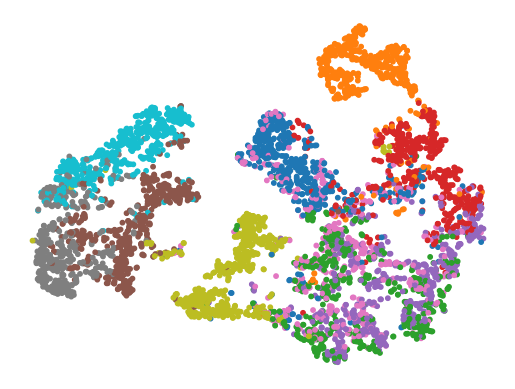

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 10, y_valid, cmap='tab10')
plt.axis('off')
plt.show()

이 그림을 조금 더 예쁘게 그린다:

그림 저장 fashion_mnist_visualization_plot


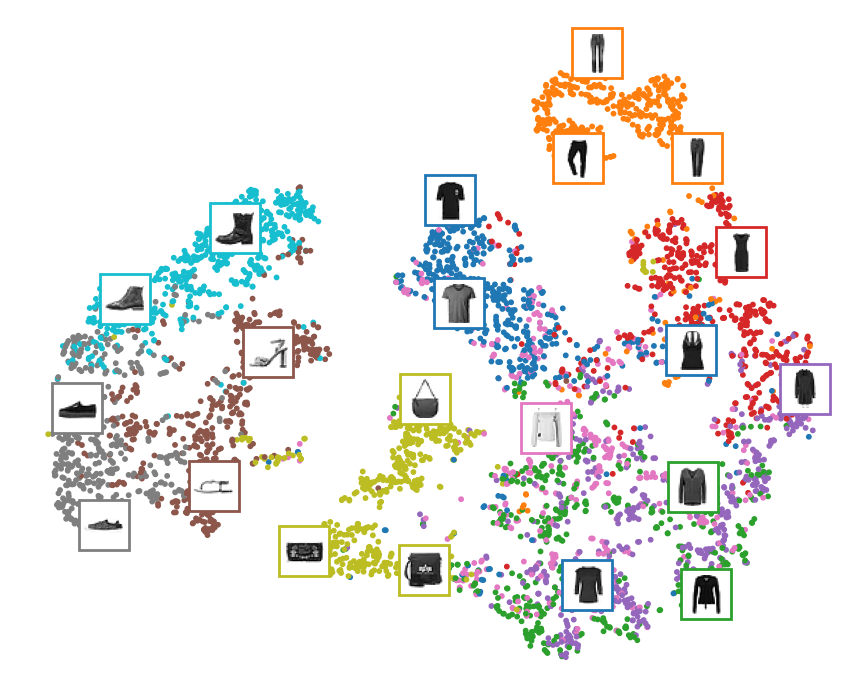

In [16]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html 참고
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 10, y_valid, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, 1)
    if np.amin(dist) > .02:  # 다른 이미지에서 충분히 멀리 떨어져 있는 경우
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap='binary'),
            position,
            bboxprops={'edgecolor': cmap(y_valid[index]), 'lw': 2}
        )
        plt.gca().add_artist(imagebox)
plt.axis('off')
save_fig('fashion_mnist_visualization_plot')
plt.show()

### 가중치 묶기

인코더의 가중치를 전치(transpose)하여 디코더의 가중치로 사용하는 식으로 인코더와 디코더의 가중치를 묶는 일은 흔하다. 이렇게 하려면 사용자 정의 층을 사용해야 한다.

In [17]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.biases = None
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight('bias', [self.dense.input_shape[-1]], initializer='zeros')
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.linalg.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [18]:
keras.backend.clear_session()
dense_1 = keras.layers.Dense(100, 'selu')
dense_2 = keras.layers.Dense(30, 'selu')
tied_encoder = keras.Sequential([keras.layers.Flatten(input_shape=[28, 28]), dense_1, dense_2])
tied_decoder = keras.Sequential(
    [DenseTranspose(dense_2, 'selu'), DenseTranspose(dense_1, 'sigmoid'), keras.layers.Reshape([28, 28])]
)
tied_ae = keras.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(keras.optimizers.experimental.SGD(1.5), 'binary_crossentropy', [rounded_accuracy])
# history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = tied_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3275 - rounded_accuracy: 0.8953 - val_loss: 0.3095 - val_rounded_accuracy: 0.9083
Epoch 2/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2981 - rounded_accuracy: 0.9214 - val_loss: 0.2967 - val_rounded_accuracy: 0.9215
Epoch 3/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2921 - rounded_accuracy: 0.9272 - val_loss: 0.2914 - val_rounded_accuracy: 0.9292
Epoch 4/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2890 - rounded_accuracy: 0.9302 - val_loss: 0.2893 - val_rounded_accuracy: 0.9325
Epoch 5/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2869 - rounded_accuracy: 0.9321 - val_loss: 0.2873 - val_rounded_accuracy: 0.9333
Epoch 6/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2855 - rounded_accuracy: 0.9333 - val_loss: 0.2860 - val_rounded_accuracy: 0.9356


1/1 [==============================] - 0s 67ms/step


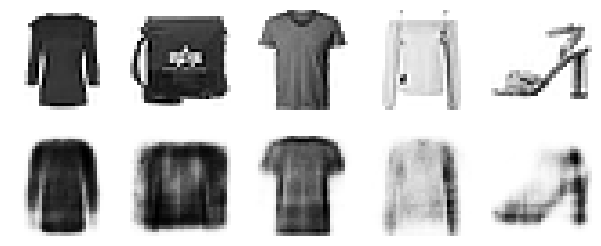

In [19]:
show_reconstructions(tied_ae)
plt.show()

### 한 번에 오토인코더 한 개씩 훈련하기

In [20]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.Sequential([keras.layers.Dense(n_neurons, 'selu', input_shape=[n_inputs])])
    decoder = keras.Sequential([keras.layers.Dense(n_inputs, output_activation)])
    autoencoder = keras.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [21]:
flatten = keras.layers.Flatten()
X_train_flat = flatten(X_train)  # .reshape(-1, 28 * 28)과 동일
X_valid_flat = flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100,
    X_train_flat,
    X_valid_flat,
    'binary_crossentropy',
    keras.optimizers.experimental.SGD(1.5),
    # output_activation='sigmoid',
    # metrics=[rounded_accuracy]
    8,
    'sigmoid',
    [rounded_accuracy]
)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, 'mse', keras.optimizers.experimental.SGD(.05), output_activation='selu'
)

Epoch 1/8
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3448 - rounded_accuracy: 0.8872 - val_loss: 0.3121 - val_rounded_accuracy: 0.9147
Epoch 2/8
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3037 - rounded_accuracy: 0.9203 - val_loss: 0.3005 - val_rounded_accuracy: 0.9247
Epoch 3/8
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2949 - rounded_accuracy: 0.9283 - val_loss: 0.2935 - val_rounded_accuracy: 0.9312
Epoch 4/8
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2893 - rounded_accuracy: 0.9337 - val_loss: 0.2891 - val_rounded_accuracy: 0.9353
Epoch 5/8
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2856 - rounded_accuracy: 0.9372 - val_loss: 0.2860 - val_rounded_accuracy: 0.9383
Epoch 6/8
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2830 - rounded_accuracy: 0.9398 - val_loss: 0.2837 - val_rounded_accuracy: 0.9408
Epoch 7/8
1719/1719 [=========================

In [22]:
stacked_ae_1_by_1 = keras.Sequential(
    [keras.layers.Flatten(input_shape=[28, 28]), enc1, enc2, dec2, dec1, keras.layers.Reshape([28, 28])]
)

1/1 [==============================] - 0s 77ms/step


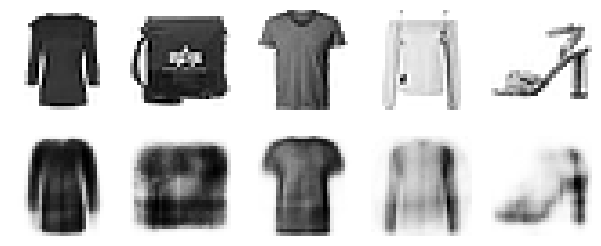

In [23]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [24]:
stacked_ae_1_by_1.compile(keras.optimizers.experimental.SGD(.1), 'binary_crossentropy', [rounded_accuracy])
# history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2876 - rounded_accuracy: 0.9335 - val_loss: 0.2892 - val_rounded_accuracy: 0.9332
Epoch 2/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2872 - rounded_accuracy: 0.9339 - val_loss: 0.2890 - val_rounded_accuracy: 0.9336
Epoch 3/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2870 - rounded_accuracy: 0.9341 - val_loss: 0.2889 - val_rounded_accuracy: 0.9337
Epoch 4/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2869 - rounded_accuracy: 0.9342 - val_loss: 0.2887 - val_rounded_accuracy: 0.9339
Epoch 5/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2886 - val_rounded_accuracy: 0.9341
Epoch 6/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2866 - rounded_accuracy: 0.9345 - val_loss: 0.2884 - val_rounded_accuracy: 0.9342


1/1 [==============================] - 0s 74ms/step


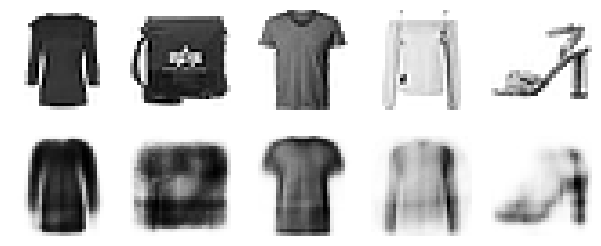

In [25]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## 합성곱 오토인코더

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만든다.

In [26]:
conv_encoder = keras.Sequential(
    [
        keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
        keras.layers.Conv2D(16, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(32, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(64, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2)
    ]
)
conv_decoder = keras.Sequential(
    [
        keras.layers.Conv2DTranspose(32, 3, 2, activation='selu', input_shape=[3, 3, 64]),
        keras.layers.Conv2DTranspose(16, 3, 2, 'same', activation='selu'),
        keras.layers.Conv2DTranspose(1, 3, 2, 'same', activation='sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
conv_ae = keras.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
history = conv_ae.fit(X_train, X_train, epochs=4, validation_data=(X_valid, X_valid))

Epoch 1/4
1719/1719 [==============================] - 23s 7ms/step - loss: 0.3025 - rounded_accuracy: 0.9191 - val_loss: 0.2854 - val_rounded_accuracy: 0.9360
Epoch 2/4
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2758 - rounded_accuracy: 0.9418 - val_loss: 0.2733 - val_rounded_accuracy: 0.9466
Epoch 3/4
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2708 - rounded_accuracy: 0.9467 - val_loss: 0.2704 - val_rounded_accuracy: 0.9492
Epoch 4/4
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2681 - rounded_accuracy: 0.9495 - val_loss: 0.2705 - val_rounded_accuracy: 0.9483


In [27]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

1/1 [==============================] - 0s 182ms/step


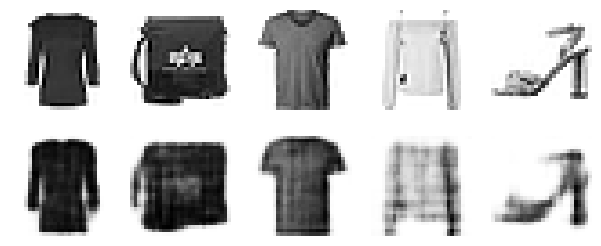

In [28]:
show_reconstructions(conv_ae)
plt.show()

## 순환 오토인코더

In [29]:
recurrent_encoder = keras.Sequential(
    [keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]), keras.layers.LSTM(30)]
)
recurrent_decoder = keras.Sequential(
    [
        keras.layers.RepeatVector(28, input_shape=[30]),
        keras.layers.LSTM(100, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(28, 'sigmoid'))
    ]
)
recurrent_ae = keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(keras.optimizers.experimental.SGD(.1), 'binary_crossentropy', [rounded_accuracy])

In [30]:
# history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = recurrent_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 39s 18ms/step - loss: 0.5022 - rounded_accuracy: 0.7644 - val_loss: 0.4303 - val_rounded_accuracy: 0.8270


1/1 [==============================] - 1s 900ms/step


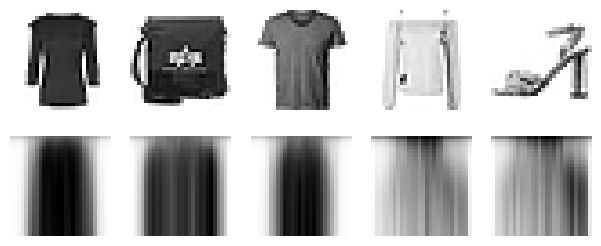

In [31]:
show_reconstructions(recurrent_ae)
plt.show()

## 잡음 제거 오토인코더

가우시안 잡음을 사용한다:

In [32]:
denoising_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.GaussianNoise(.2),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(30, 'selu')
    ]
)
denoising_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
denoising_ae = keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(keras.optimizers.experimental.SGD(1), 'binary_crossentropy', [rounded_accuracy])
# history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = denoising_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3481 - rounded_accuracy: 0.8794 - val_loss: 0.3166 - val_rounded_accuracy: 0.9071
Epoch 2/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3116 - rounded_accuracy: 0.9103 - val_loss: 0.3071 - val_rounded_accuracy: 0.9157
Epoch 3/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3053 - rounded_accuracy: 0.9157 - val_loss: 0.3029 - val_rounded_accuracy: 0.9185
Epoch 4/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3016 - rounded_accuracy: 0.9188 - val_loss: 0.2999 - val_rounded_accuracy: 0.9220
Epoch 5/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2988 - rounded_accuracy: 0.9214 - val_loss: 0.2975 - val_rounded_accuracy: 0.9225
Epoch 6/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2966 - rounded_accuracy: 0.9233 - val_loss: 0.2956 - val_rounded_accuracy: 0.9238


1/1 [==============================] - 0s 72ms/step


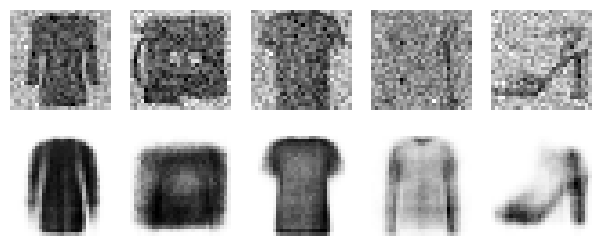

In [33]:
noise = keras.layers.GaussianNoise(.2)
show_reconstructions(denoising_ae, noise(X_valid, True))
plt.show()

드롭아웃을 사용한다:

In [34]:
dropout_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dropout(.5),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(30, 'selu')
    ]
)
dropout_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
dropout_ae = keras.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = dropout_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3517 - rounded_accuracy: 0.8750 - val_loss: 0.3182 - val_rounded_accuracy: 0.9046
Epoch 2/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3171 - rounded_accuracy: 0.9040 - val_loss: 0.3103 - val_rounded_accuracy: 0.9122
Epoch 3/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3112 - rounded_accuracy: 0.9086 - val_loss: 0.3074 - val_rounded_accuracy: 0.9158
Epoch 4/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3079 - rounded_accuracy: 0.9114 - val_loss: 0.3028 - val_rounded_accuracy: 0.9192
Epoch 5/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3054 - rounded_accuracy: 0.9134 - val_loss: 0.3011 - val_rounded_accuracy: 0.9203
Epoch 6/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3035 - rounded_accuracy: 0.9150 - val_loss: 0.2994 - val_rounded_accuracy: 0.9218


1/1 [==============================] - 0s 77ms/step
그림 저장 dropout_denoising_plot


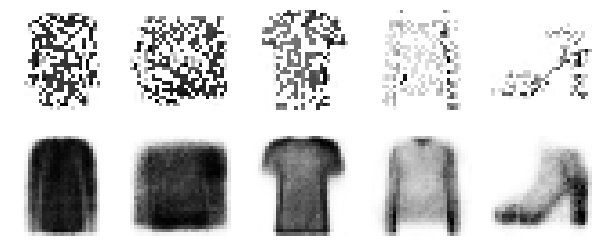

In [35]:
dropout = keras.layers.Dropout(.5)
show_reconstructions(dropout_ae, dropout(X_valid, True))
save_fig('dropout_denoising_plot', False)

## 희소 오토인코더

간단한 적층 오토인코더를 만들어 희소 오토인코더와 비교한다. 이번에는 코딩 층에 시그모이드 활성화 함수를 사용하여 코딩 값의 범위가 0~1 사이가 되도록 만든다:

In [36]:
simple_encoder = keras.Sequential(
    [keras.layers.Flatten(input_shape=[28, 28]), keras.layers.Dense(100, 'selu'), keras.layers.Dense(30, 'sigmoid')]
)
simple_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
simple_ae = keras.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = simple_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = simple_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4366 - rounded_accuracy: 0.7923 - val_loss: 0.3781 - val_rounded_accuracy: 0.8499
Epoch 2/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3612 - rounded_accuracy: 0.8667 - val_loss: 0.3508 - val_rounded_accuracy: 0.8770
Epoch 3/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3407 - rounded_accuracy: 0.8855 - val_loss: 0.3359 - val_rounded_accuracy: 0.8897
Epoch 4/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3268 - rounded_accuracy: 0.8972 - val_loss: 0.3240 - val_rounded_accuracy: 0.9017
Epoch 5/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3198 - rounded_accuracy: 0.9025 - val_loss: 0.3199 - val_rounded_accuracy: 0.9036
Epoch 6/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3164 - rounded_accuracy: 0.9052 - val_loss: 0.3165 - val_rounded_accuracy: 0.9069


1/1 [==============================] - 0s 82ms/step


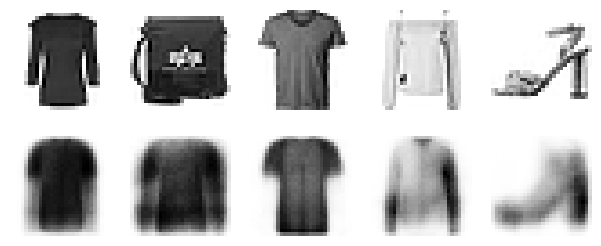

In [37]:
show_reconstructions(simple_ae)
plt.show()

활성화 히스토그램을 출력하기 위한 함수를 만든다:

In [38]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), widths * .8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: f'{int(np.around(100 * y))}%'))
    ax.grid(True)

In [39]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)
    fig, [ax1, ax2] = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], 'k--', label=f'Overall Mean = {mean:.2f}')
    ax1.legend(loc='upper center', fontsize=14)
    ax1.set_xlabel('Activation')
    ax1.set_ylabel('% Activations')
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], 'k--')
    ax2.set_xlabel('Neuron Mean Activation')
    ax2.set_ylabel('% Neurons')
    ax2.axis([0, 1, 0, height])

이 함수를 사용해 인코딩 층의 활성화에 대한 히스토그램을 출력한다. 왼쪽의 히스토그램은 전체 활성화의 분포이다. 0과 1에 가까운 값이 전체적으로 더 많다. 이는 시그모이드 함수가 포화되는 특성 때문이다. 오른쪽의 히스토그램은 평균 뉴런의 분포이다. 대부분의 뉴런이 0.5에 가까운 평균 활성화를 가진다. 두 히스토그램은 각 뉴런이 50% 확률로 0이나 1에 가까운 값에 활성화된다는 것을 보인다. 하지만 일부 뉴런은 거의 항상 활성화된다(오른쪽 히스토그램의 오른쪽편).

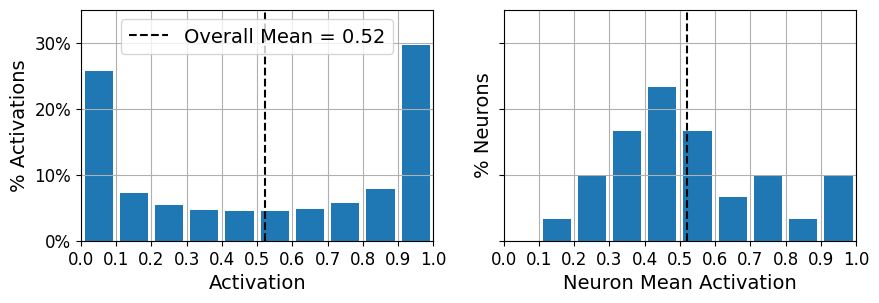

In [40]:
plot_activations_histogram(simple_encoder, .35)
plt.show()

코딩 층에 $\ell_1$ 규제를 추가한다:

In [41]:
sparse_l1_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(300, 'sigmoid'),
        keras.layers.ActivityRegularization(1e-3)  # 또는 이전 레이어에 activity_regularizer=keras.regularizers.L1(1e-3)을 추가
    ]
)
sparse_l1_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[300]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
sparse_l1_ae = keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = sparse_l1_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4337 - rounded_accuracy: 0.8130 - val_loss: 0.3844 - val_rounded_accuracy: 0.8593
Epoch 2/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3697 - rounded_accuracy: 0.8681 - val_loss: 0.3652 - val_rounded_accuracy: 0.8712
Epoch 3/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3567 - rounded_accuracy: 0.8783 - val_loss: 0.3531 - val_rounded_accuracy: 0.8788
Epoch 4/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3456 - rounded_accuracy: 0.8865 - val_loss: 0.3439 - val_rounded_accuracy: 0.8876
Epoch 5/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3380 - rounded_accuracy: 0.8918 - val_loss: 0.3366 - val_rounded_accuracy: 0.8929


1/1 [==============================] - 0s 83ms/step


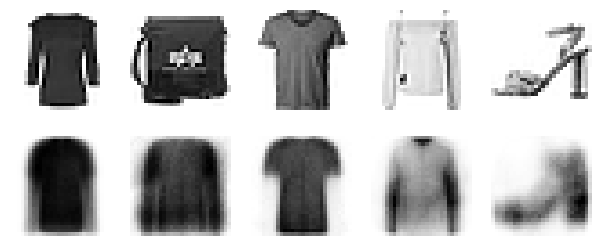

In [42]:
show_reconstructions(sparse_l1_ae)

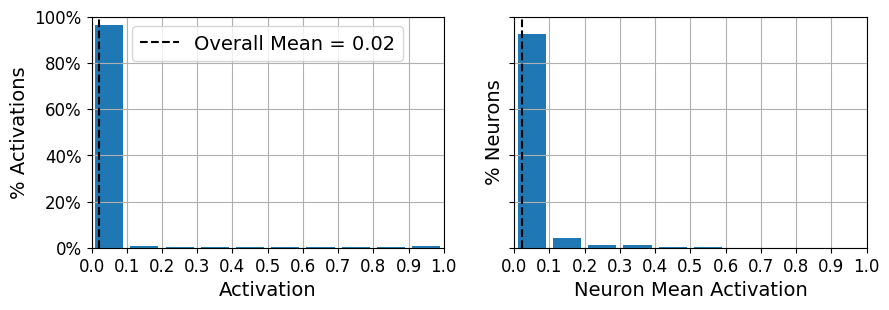

In [43]:
plot_activations_histogram(sparse_l1_encoder, 1.)
plt.show()

희소성을 위해 KL 발산을 사용하여 0%가 아니라 10% 희소성을 만든다:

그림 저장 sparsity_loss_plot


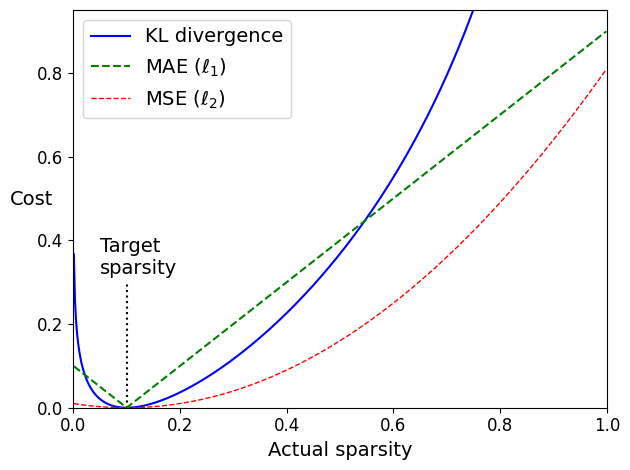

In [44]:
p = .1
q = np.linspace(.001, .999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.absolute(p - q)
plt.plot([p, p], [0, .3], 'k:')
plt.text(.05, .32, 'Target\nsparsity', fontsize=14)
plt.plot(q, kl_div, 'b-', label='KL divergence')
plt.plot(q, mae, 'g--', label=r'MAE ($\ell_1$)')
plt.plot(q, mse, 'r--', linewidth=1, label=r'MSE ($\ell_2$)')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('Actual sparsity')
plt.ylabel('Cost', rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig('sparsity_loss_plot')

In [45]:
kl_divergence = keras.metrics.kl_divergence


class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.math.reduce_mean(inputs, 0)
        return self.weight * (
                kl_divergence(self.target, mean_activities) + kl_divergence(1. - self.target, 1. - mean_activities)
        )

In [46]:
kld_reg = KLDivergenceRegularizer(.05)
sparse_kl_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(300, 'sigmoid', activity_regularizer=kld_reg)
    ]
)
sparse_kl_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[300]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
sparse_kl_ae = keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = sparse_kl_ae.fit(X_train, X_train, epochs=4, validation_data=(X_valid, X_valid))

Epoch 1/4
1719/1719 [==============================] - 12s 6ms/step - loss: 0.4138 - rounded_accuracy: 0.8128 - val_loss: 0.3695 - val_rounded_accuracy: 0.8605
Epoch 2/4
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3507 - rounded_accuracy: 0.8791 - val_loss: 0.3418 - val_rounded_accuracy: 0.8863
Epoch 3/4
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3317 - rounded_accuracy: 0.8942 - val_loss: 0.3272 - val_rounded_accuracy: 0.8994
Epoch 4/4
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3213 - rounded_accuracy: 0.9029 - val_loss: 0.3207 - val_rounded_accuracy: 0.9049


1/1 [==============================] - 0s 99ms/step


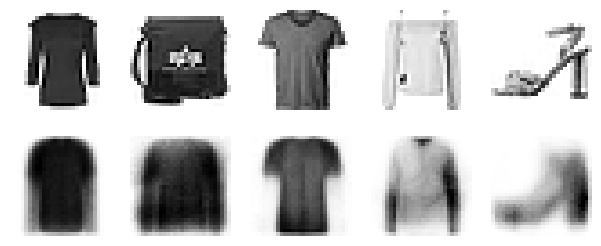

In [47]:
show_reconstructions(sparse_kl_ae)

그림 저장 sparse_autoencoder_plot


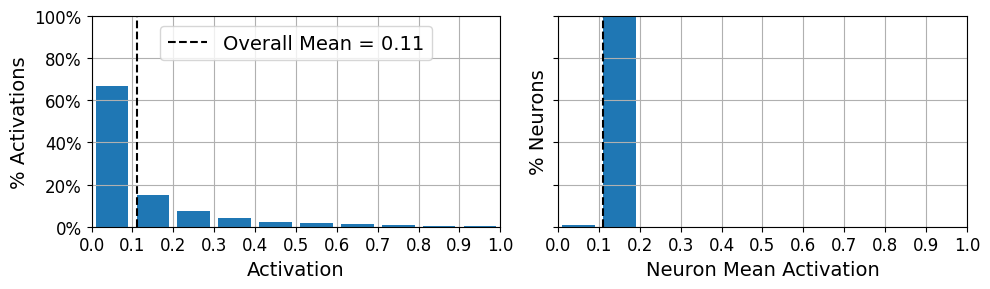

In [48]:
plot_activations_histogram(sparse_kl_encoder)
save_fig('sparse_autoencoder_plot')
plt.show()

## 변이형 오토인코더

In [49]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.math.exp(log_var / 2) + mean

In [50]:
codings_size = 10
inputs = keras.Input([28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, 'selu')(z)
z = keras.layers.Dense(100, 'selu')(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
decoder_inputs = keras.Input([codings_size])
x = keras.layers.Dense(100, 'selu')(decoder_inputs)
x = keras.layers.Dense(150, 'selu')(x)
x = keras.layers.Dense(28 * 28, 'sigmoid')(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])
latent_loss = -0.5 * tf.math.reduce_sum(
    1 + codings_log_var - tf.math.exp(codings_log_var) - tf.math.square(codings_mean), -1
)
variational_ae.add_loss(tf.math.reduce_mean(latent_loss) / 784.)
variational_ae.compile(loss='binary_crossentropy', metrics=[rounded_accuracy])
# history = variational_ae.fit(X_train, X_train, 128, 25, validation_data=(X_valid, X_valid))
history = variational_ae.fit(X_train, X_train, 128, 12, validation_data=(X_valid, X_valid))

Epoch 1/12
430/430 [==============================] - 5s 10ms/step - loss: 0.3879 - rounded_accuracy: 0.8630 - val_loss: 0.3532 - val_rounded_accuracy: 0.8882
Epoch 2/12
430/430 [==============================] - 4s 10ms/step - loss: 0.3426 - rounded_accuracy: 0.8980 - val_loss: 0.3349 - val_rounded_accuracy: 0.9053
Epoch 3/12
430/430 [==============================] - 4s 10ms/step - loss: 0.3324 - rounded_accuracy: 0.9054 - val_loss: 0.3335 - val_rounded_accuracy: 0.9002
Epoch 4/12
430/430 [==============================] - 4s 10ms/step - loss: 0.3276 - rounded_accuracy: 0.9088 - val_loss: 0.3265 - val_rounded_accuracy: 0.9112
Epoch 5/12
430/430 [==============================] - 4s 10ms/step - loss: 0.3246 - rounded_accuracy: 0.9114 - val_loss: 0.3289 - val_rounded_accuracy: 0.9120
Epoch 6/12
430/430 [==============================] - 4s 10ms/step - loss: 0.3224 - rounded_accuracy: 0.9132 - val_loss: 0.3221 - val_rounded_accuracy: 0.9130
Epoch 7/12
430/430 [==========================

1/1 [==============================] - 0s 132ms/step


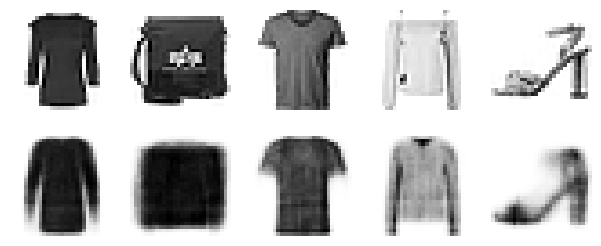

In [51]:
show_reconstructions(variational_ae)
plt.show()

### 패션 MNIST 이미지 생성하기

In [60]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, -1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, 'binary')
        plt.axis('off')

몇 개의 랜덤한 코딩을 생성하고 이를 디코딩하여 결과 이미지를 출력한다:

그림 저장 vae_generated_images_plot


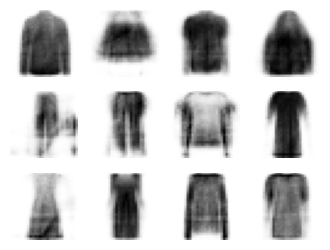

In [61]:
codings = tf.random.normal([12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig('vae_generated_images_plot', False)

이미지 사이에서 의미 보간을 수행한다:

그림 저장 semantic_interpolation_plot


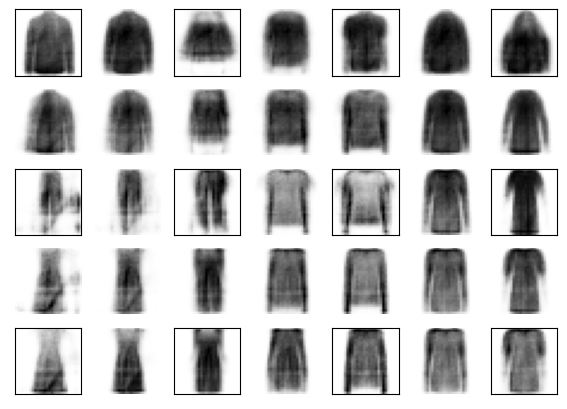

In [77]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, [5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()
plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index % 7 % 2 == 0 and index // 7 % 2 == 0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis('off')
    plt.imshow(image, 'binary')
save_fig('semantic_interpolation_plot', False)